In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


D:\zoonotic-radar\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your processed dataset
file_path = "master_feature_table_v2.csv"
df = pd.read_csv(file_path)

print(f" Loaded dataset: {df.shape[0]} species × {df.shape[1]} features")
df.head()


 Loaded dataset: 6153 species × 19 features


,species_name,total_trade_records,total_quantity,num_importers,num_exporters,num_trade_years,avg_quantity_per_trade,trade_diversity,trade_intensity,log_total_quantity,log_trade_records,pathogen_network_degree,avg_neighbor_degree,clustering_coefficient,max_degree_variant,is_pathogen_hub,is_high_risk_reservoir,normalized_degree,high_risk_label
0,Ailurus fulgens,1019,2.331000e+03,51,42,50,2.287537,2142,2.287537,7.754482,6.927558,384,498.687500,0.637117,384,0,0,0.257200,1
1,Aldabrachelys gigantea,3117,7.308400e+04,78,53,49,23.446904,4134,23.446904,11.199378,8.044947,0,0.000000,0.000000,0,0,0,0.000000,0
2,Alligator mississippiensis,4795470,2.178152e+08,245,196,50,45.421030,48020,45.421030,19.199158,15.383182,268,569.955224,1.000000,268,0,0,0.179504,1
3,Anodorhynchus leari,242,4.135900e+03,18,17,29,17.090496,306,17.090496,8.327702,5.493061,274,543.828467,1.000000,274,0,0,0.183523,1
4,Balaenidae spp.,91,6.330800e+02,18,23,29,6.956923,414,6.956923,6.452175,4.521789,0,0.000000,0.000000,0,0,0,0.000000,0


### Build Similarity Graph (Feature-based)

Create a feature-similarity graph:
1. Standardize numeric features (e.g., `StandardScaler`)  
2. Compute pairwise cosine similarity and construct k-NN edges (k = 8)  
3. Convert edges and node features to a `torch_geometric.data.Data` object


In [3]:
from sklearn.metrics.pairwise import cosine_similarity

# Separate features and target
X = df.drop(columns=["species_name", "high_risk_label"], errors='ignore')
y = df["high_risk_label"].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Build similarity graph (k-nearest neighbors)
k = 8  
similarity = cosine_similarity(X_scaled)
np.fill_diagonal(similarity, 0)

# Create edge index
edges = []
for i in range(similarity.shape[0]):
    top_k = np.argsort(similarity[i])[-k:]
    for j in top_k:
        edges.append([i, j])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print(f"Created graph with {X.shape[0]} nodes and {edge_index.shape[1]} edges")

# Convert to PyTorch Geometric Data object
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)
data


Created graph with 6153 nodes and 49224 edges


Data(x=[6153, 17], edge_index=[2, 49224], y=[6153])

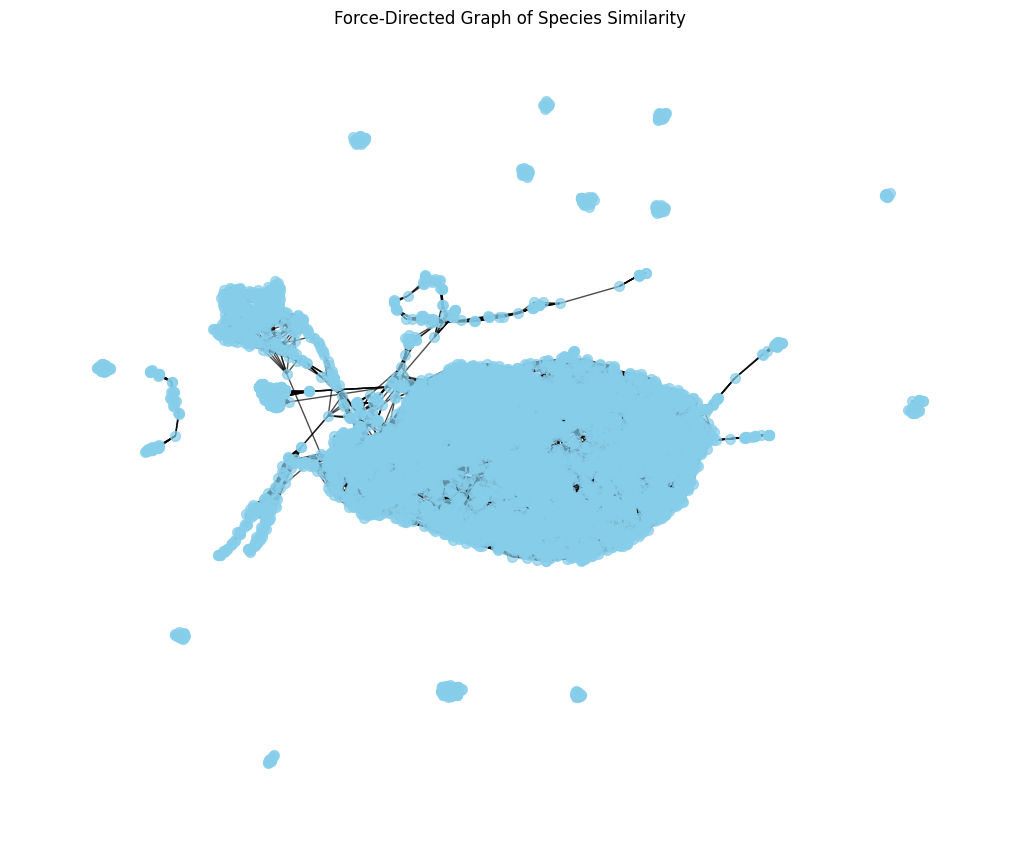

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Build graph (edges already created as 'edge_index')
G = nx.Graph()
edges_np = edge_index.t().cpu().numpy()
G.add_edges_from(edges_np)

# Draw a force-directed layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Force-directed positions
nx.draw(G, pos, node_size=50, node_color='skyblue', alpha=0.7, with_labels=False)
plt.title("Force-Directed Graph of Species Similarity")
plt.show()


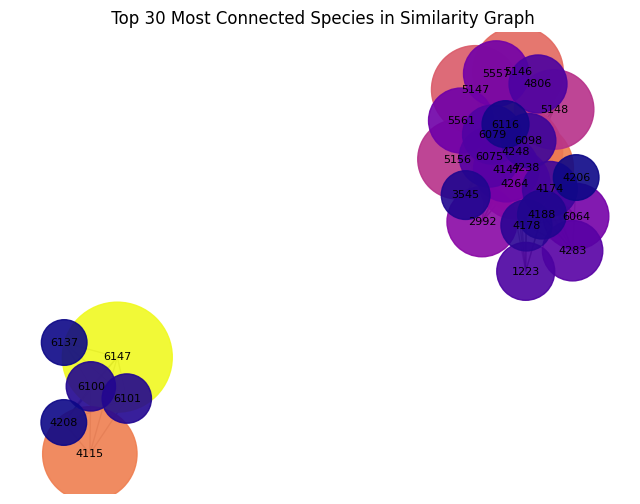

Top 30 most connected species:
 1. Species Index 6098 → 209 connections
 2. Species Index 4238 → 156 connections
 3. Species Index 4248 → 154 connections
 4. Species Index 4264 → 152 connections
 5. Species Index 6079 → 142 connections
 6. Species Index 4147 → 134 connections
 7. Species Index 6116 → 109 connections
 8. Species Index 6075 → 109 connections
 9. Species Index 5146 → 86 connections
10. Species Index 5156 → 85 connections
11. Species Index 4188 → 75 connections
12. Species Index 5148 → 74 connections
13. Species Index 5147 → 74 connections
14. Species Index 2992 → 73 connections
15. Species Index 4178 → 63 connections
16. Species Index 6147 → 62 connections
17. Species Index 4283 → 60 connections
18. Species Index 4174 → 58 connections
19. Species Index 1223 → 58 connections
20. Species Index 4115 → 52 connections
21. Species Index 6101 → 51 connections
22. Species Index 4206 → 45 connections
23. Species Index 6100 → 42 connections
24. Species Index 6064 → 42 connections
2

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a NetworkX graph from edge_index
G = nx.Graph()
edges_np = edge_index.t().cpu().numpy()
G.add_edges_from(edges_np)

# Compute node degrees (number of connections) 
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:30]
top_node_ids = [n for n, _ in top_nodes]
top_degrees = [d for _, d in top_nodes]

# Subgraph for top 30 nodes
G_top = G.subgraph(top_node_ids)

# Draw the network 
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_top, seed=42, k=0.3)
nx.draw_networkx_nodes(
    G_top, pos,
    node_size=[v * 30 for v in top_degrees],
    node_color=top_degrees,
    cmap='plasma',
    alpha=0.9
)
nx.draw_networkx_edges(G_top, pos, alpha=0.4)
nx.draw_networkx_labels(G_top, pos, font_size=8)

plt.title(" Top 30 Most Connected Species in Similarity Graph", fontsize=12)
plt.axis("off")
plt.show()

# Print the top nodes with their degree
print("Top 30 most connected species:")
for idx, (node, deg) in enumerate(top_nodes, 1):
    print(f"{idx:2d}. Species Index {node} → {deg} connections")

### Train / Test Split (Node-level)

Create train and test boolean masks (stratified by the weak supervision label):
- 80% train, 20% test  
- Attach `train_mask` and `test_mask` to the `Data` object for use during GNN training.


In [6]:
# Random split (80% train, 20% test)
train_mask, test_mask = train_test_split(range(len(y)), test_size=0.2, stratify=y, random_state=42)

data.train_mask = torch.zeros(len(y), dtype=torch.bool)
data.test_mask = torch.zeros(len(y), dtype=torch.bool)
data.train_mask[train_mask] = True
data.test_mask[test_mask] = True


### Define Graph Neural Network (GraphSAGE)

Model architecture:
- Two-layer GraphSAGE (`SAGEConv`)  
- ReLU activation, dropout (p=0.4) between layers  
- Final output: log-softmax over classes (binary classification)


In [7]:
from torch_geometric.nn import SAGEConv

# Define a Graph Neural Network using GraphSAGE convolutional layers
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels=data.num_node_features, hidden_channels=64, out_channels=2).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
def test():
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

# Training loop
epochs = 100
for epoch in range(epochs):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.3f}")


Epoch 000 | Loss: 0.8240 | Test Acc: 0.570
Epoch 010 | Loss: 0.1025 | Test Acc: 0.966
Epoch 020 | Loss: 0.0313 | Test Acc: 0.990
Epoch 030 | Loss: 0.0187 | Test Acc: 0.993
Epoch 040 | Loss: 0.0160 | Test Acc: 0.996
Epoch 050 | Loss: 0.0151 | Test Acc: 0.994
Epoch 060 | Loss: 0.0140 | Test Acc: 0.995
Epoch 070 | Loss: 0.0123 | Test Acc: 0.994
Epoch 080 | Loss: 0.0116 | Test Acc: 0.996
Epoch 090 | Loss: 0.0128 | Test Acc: 0.996



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1165
           1       0.94      0.97      0.96        66

    accuracy                           1.00      1231
   macro avg       0.97      0.98      0.98      1231
weighted avg       1.00      1.00      1.00      1231



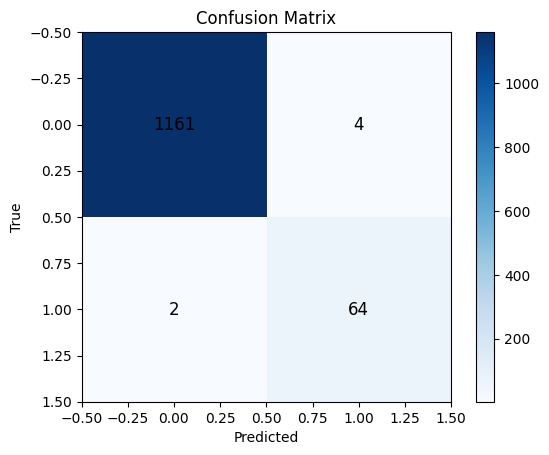

In [9]:
model.eval()
pred = model(data).argmax(dim=1).cpu().numpy()

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y[data.test_mask.cpu()], pred[data.test_mask.cpu()]))

cm = confusion_matrix(y[data.test_mask.cpu()], pred[data.test_mask.cpu()])
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

plt.colorbar()

plt.show()


In [10]:
torch.save(model.state_dict(), "gnn_species_risk_model.pt")
print(" Model saved to gnn_species_risk_model.pt")


 Model saved to gnn_species_risk_model.pt
